In [10]:
###-----------------
### Import libraries
###-----------------
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.model_selection import  train_test_split # Import function to split dataset into training and testing subsets
from sklearn.metrics import * # Import function to calculate various metric

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from tensorflow.keras.applications import DenseNet169


In [12]:
###----------------------
### Some basic parameters
###----------------------

# inpDir = Path('..') / '..' / 'input'
# outDir = Path('..') / 'output'
# modelDir = Path('..') / 'models'
# subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 100 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
# TRAIN_SIZE=int(18*BATCH_SIZE)


WEIGHT_DECAY = 0.001
PATENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 5
MIN_LR = 1e-6

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [13]:
data_dir = r"D:\dnn_input\flower_photos"
# 2. Define parameters for image loading
IMAGE_SIZE = (190, 190) # Standardize image dimensions
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2 # 20% of the data will be used for validation

train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20, # Rotate images randomly by up to 20 degrees
    width_shift_range=0.2, # Shift images horizontally by up to 20%
    height_shift_range=0.2, # Shift images vertically by up to 20%
    shear_range=0.2, # Apply shear transformation
    zoom_range=0.2, # Zoom in on images"
    horizontal_flip=True, # Flip images horizontally
    fill_mode='nearest', # Strategy for filling in new pixels created by rotation/shift
    validation_split=VALIDATION_SPLIT # THIS IS KEY for the split
)

# Load the training images from the directory
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    subset='training', # Specify this is the training set
    seed=42 # Set a seed for reproducibility
)


validation_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    validation_split=VALIDATION_SPLIT # THIS IS KEY for the split
)

# Load the validation images from the directory
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation', # Specify this is the validation set
    seed=42 # Use the same seed for consistent splitting
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [17]:
train_generator.num_classes

5

## transfer Learninig

In [14]:
IMG_HEIGHT,IMG_WIDTH = 190,190
input_shape = [IMG_HEIGHT,IMG_WIDTH,3]
densenet_model = DenseNet169(weights = 'imagenet',include_top = False,input_shape=input_shape)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [21]:
for layer in densenet_model.layers:
    layer.trainable = False

In [22]:
densenet_model.summary()

Model: "densenet169"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 190, 190,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 196, 196,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 95, 95,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 95, 95,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 95, 95,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 97, 97,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 48, 48,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 48, 48,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 48, 48,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 48, 48,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 48, 48,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 48, 48,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 48, 48,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 48, 48,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 48, 48,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 48, 48,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 48, 48,    │     12,288 │ conv2_block2_0_r

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,642,880 (48.23 MB)

In [23]:
def build_model(d_net,num_classes):
    model = tf.keras.Sequential()
    model.add(d_net)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(num_classes))

    return model

In [24]:
model = build_model(densenet_model,train_generator.num_classes)

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ (None, 6, 6, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         8,325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,651,205 (48.26 MB)

 Trainable params: 8,325 (32.52 KB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [26]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=MIN_LR,
)

es_callback = tf.keras.callbacks.EarlyStopping(

    monitor="val_loss",
    min_delta=0,
    patience=PATENCE,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(ALPHA),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history= model.fit(train_generator,
                   validation_data=validation_generator,
                   epochs=EPOCHS,callbacks=[es_callback,lr_callback])

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.6628 - loss: 0.8921 - val_accuracy: 0.8276 - val_loss: 0.4968 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8421 - loss: 0.4714 - val_accuracy: 0.8564 - val_loss: 0.3977 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8690 - loss: 0.3840 - val_accuracy: 0.8796 - val_loss: 0.3478 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8853 - loss: 0.3255 - val_accuracy: 0.8865 - val_loss: 0.3227 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8915 - loss: 0.3107 - val_accuracy: 0.8919 - val_loss: 0.2996 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8935 - loss: 0.2976 - val_accuracy: 0.8960 - val_loss: 0.2971 - learning_rate: 0.0010
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9064 - loss: 0.2627 - 

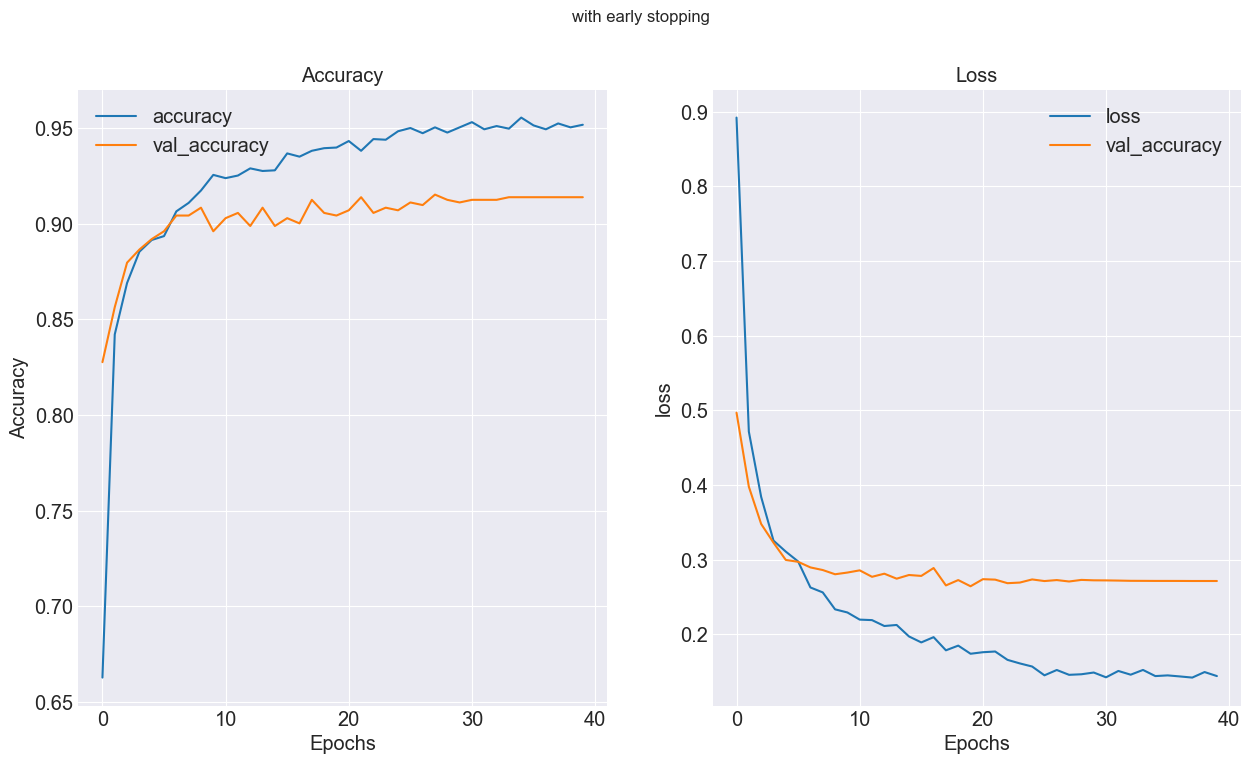

In [28]:
def plot_graph(history):
    fig,ax = plt.subplots(1,2,figsize=(15,8))
    fig.suptitle('with early stopping')
    keys=list(history.history.keys())
    ax[0].plot(history.epoch,history.history[keys[0]],label=keys[0])
    ax[0].plot(history.epoch,history.history[keys[2]],label=keys[2])
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.epoch,history.history[keys[1]],label=keys[1])
    ax[1].plot(history.epoch,history.history[keys[3]],label=keys[2])
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    

    plt.show()

plot_graph(history)